In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [2]:
ticker = 'PETR4'
dataset_se = pd.read_csv(f'./dataset/{ticker}.csv', index_col='date', parse_dates=True)

In [3]:
dataset_se.head()

,val_high,val_open,val_low,val_close,val_close_final,volume,Moving average 7,Moving average 30,Momentum 7
date,,,,,,,,,
2006-05-12,23.60,23.33,23.25,23.68,16.69,651535232,23.680000,23.680000,1.09
2006-05-15,23.50,23.25,22.40,23.45,16.53,1336049152,23.647143,23.672333,0.58
2006-05-16,23.30,23.12,22.60,22.85,16.10,671452672,23.528571,23.644667,-0.17
2006-05-17,23.08,22.73,22.00,23.00,16.21,601421120,23.431429,23.622000,0.59
2006-05-18,22.50,22.50,21.66,21.75,15.32,17677400,23.155714,23.557667,-0.62


In [4]:
# Check if has any value in the features is not applicable
dataset_se.isna().any()

val_high             False
val_open             False
val_low              False
val_close            False
val_close_final      False
volume               False
Moving average 7     False
Moving average 30    False
Momentum 7           False
dtype: bool

In [5]:
dataset_se.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3691 entries, 2006-05-12 to 2021-04-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   val_high           3691 non-null   float64
 1   val_open           3691 non-null   float64
 2   val_low            3691 non-null   float64
 3   val_close          3691 non-null   float64
 4   val_close_final    3691 non-null   float64
 5   volume             3691 non-null   int64  
 6   Moving average 7   3691 non-null   float64
 7   Moving average 30  3691 non-null   float64
 8   Momentum 7         3691 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 288.4 KB


<AxesSubplot:xlabel='date'>

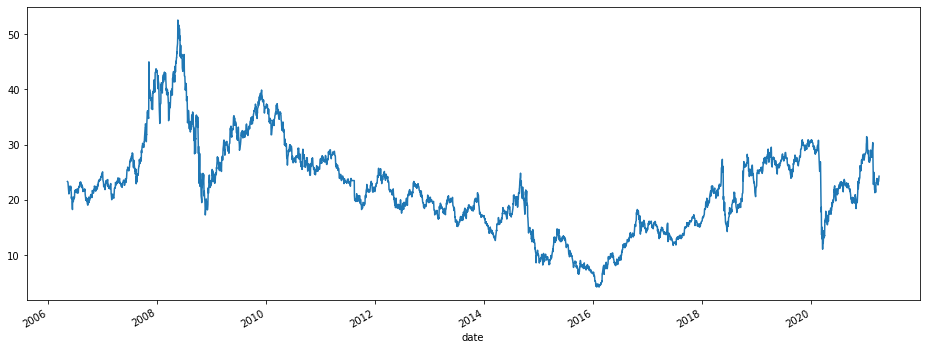

In [6]:
dataset_se['val_open'].plot(figsize=(16,6))

<AxesSubplot:xlabel='date'>

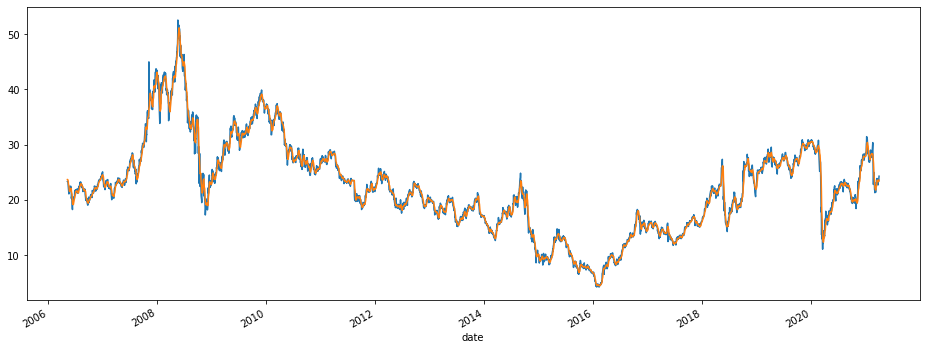

In [7]:
# Moving average of 7 days
dataset_se['val_open'].plot(figsize=(16,6))
dataset_se['Moving average 7'].plot()

<AxesSubplot:xlabel='date'>

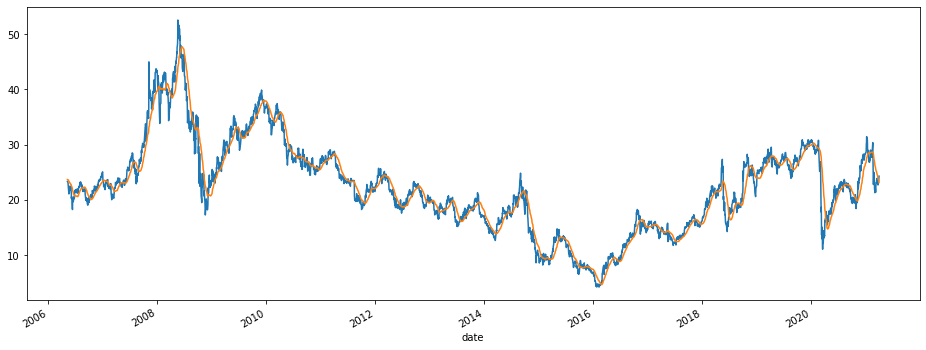

In [8]:
# Moving average of 30 days
dataset_se['val_open'].plot(figsize=(16,6))
dataset_se['Moving average 30'].plot()

## Decisions

In [9]:
def profit(df_buying_and_selling):
    return
    
def buying_and_selling_moving_average(dataset, col_stock_price, col_average_7, col_average_30):
    _buying_selling_rate = 0.2 # Taxa de compra/venda em momentos de decisão
    _decision_threshold = 0.05 # Teto/limiar de decisão
    _op_buying = 'buy'
    _op_selling = 'sel'

    stock_units = 1000 # Quantitade de ativos inicial
    prices = []
    operations = []
    units = []
    
    for index, row in dataset.iterrows():
        decision_evaluation = row[col_average_7] / row[col_average_30]
        #print(f'AV7: {row[col_average_7]},\nAV30: {row[col_average_30]},\nDE: {decision_evaluation}\n\n')

        if (decision_evaluation>1 and (decision_evaluation-1) > _decision_threshold): # (média 7 dias % < média 30) → compro
            buying_units = round(_buying_selling_rate*stock_units)

            operations.append(_op_buying)
            prices.append(row[col_stock_price])
            units.append(buying_units)

            stock_units = stock_units + buying_units

        if (decision_evaluation<1 and (-decision_evaluation+1) > _decision_threshold): #  (média 7 dias % > média 30) → vendo
            selling_units = round(_buying_selling_rate*stock_units)

            operations.append(_op_selling)
            prices.append(row[col_stock_price])
            units.append(selling_units)

            stock_units = stock_units + selling_units

    df_buying_and_selling = pd.DataFrame({'price': prices,
                                          'operation': operations,
                                          'units': units})
    
    return df_buying_and_selling


df = buying_and_selling_moving_average(dataset_se, 'val_open', 'Moving average 7', 'Moving average 30')


# Buying and Selling without NN

# Buying and Selling w/ NN

## Split Train Test

In [10]:
from pre_process_data import DataModeling

In [11]:
rules = {
    "global": ["norm"],
    "data-set-proportion": {
        "train": 0.8,
        "train-validation": 0.15,
    }
}

In [12]:
features_cols = ['val_high','volume','Moving average 7','Moving average 30', 'Momentum 7']
target_col ='val_close'
interval_fold=200

data_modeling = DataModeling(dataset_se, features_cols, target_col, rules, interval_fold, with_overlap=True)

In [13]:
traning_set_scaled, traning_set_target_scaled = data_modeling.folds[0].values_data_training()

validation_set_scaled, validation_set_scaled_target = data_modeling.folds[0].values_data_validation()

test_set_scaled, test_set_scaled_target = data_modeling.folds[0].values_data_test()

real_stock_price = data_modeling.folds[0].expected_data()

## Data Preprocessing


In [14]:
from lstm import LSTMModel

shape = traning_set_scaled.shape

model = LSTMModel(shape)
X_train, y_train = LSTMModel.create_model_entries(traning_set_scaled, traning_set_target_scaled)

X_validation, y_validation = LSTMModel.create_model_entries(validation_set_scaled, validation_set_scaled_target)

X_test, y_test = LSTMModel.create_model_entries(test_set_scaled, test_set_scaled_target)

In [15]:
model.regressor.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_validation, y_validation))

## Visualization

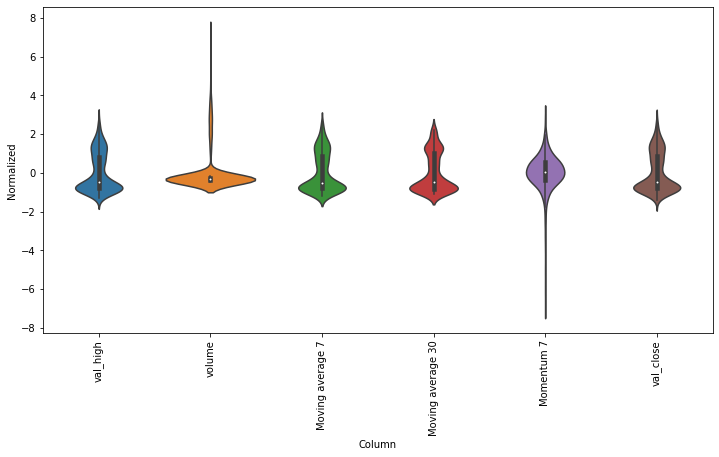

In [30]:
import seaborn as sns

df_std = data_modeling.folds[0].data_train_scaled.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data_modeling.folds[0].data_train_scaled.keys(), rotation=90)

In [17]:
predicted_stock_price = model.regressor.predict(X_test)
predicted_stock_price = DataModeling.inverse_norm(data_modeling.folds[0].train_stats, predicted_stock_price, data_modeling.folds[0].target)

In [18]:
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       200 non-null    float32
dtypes: float32(1)
memory usage: 928.0 bytes


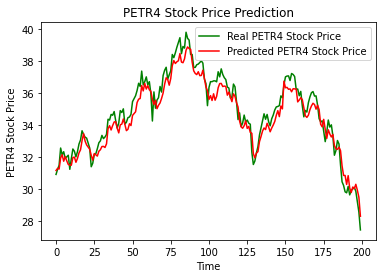

In [19]:
plt.plot(real_stock_price.values, color='green', label=f'Real {ticker} Stock Price')
plt.plot(predicted_stock_price, color='red', label=f'Predicted {ticker} Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{ticker} Stock Price')
plt.legend()
plt.show()

In [22]:
len(data_modeling.folds)

15

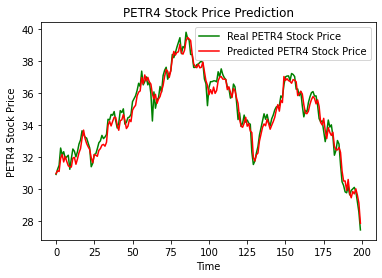

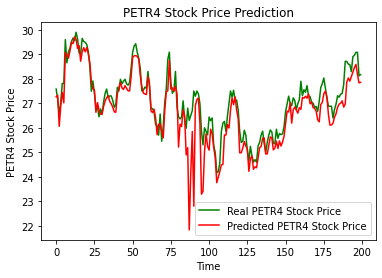

In [20]:
for fold in data_modeling.folds[0:2]:
    traning_set_scaled, traning_set_target_scaled = fold.values_data_training()

    validation_set_scaled, validation_set_scaled_target = fold.values_data_validation()

    test_set_scaled, test_set_scaled_target = fold.values_data_test()

    real_stock_price = fold.expected_data()

    X_train, y_train = LSTMModel.create_model_entries(traning_set_scaled, traning_set_target_scaled)

    X_validation, y_validation = LSTMModel.create_model_entries(validation_set_scaled, validation_set_scaled_target)

    X_test, y_test = LSTMModel.create_model_entries(test_set_scaled, test_set_scaled_target)

    model.regressor.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_validation, y_validation))

    predicted_stock_price = model.regressor.predict(X_test)
    predicted_stock_price = DataModeling.inverse_norm(fold.train_stats, predicted_stock_price, fold.target)

    plt.plot(real_stock_price.values, color='green', label=f'Real {ticker} Stock Price')
    plt.plot(predicted_stock_price, color='red', label=f'Predicted {ticker} Stock Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{ticker} Stock Price')
    plt.legend()
    plt.show()